# Opioid Addiction Project
## Notebook 04: Modeling

This notebook executes the following tasks:

1. Model Preprocessing
2. Train a machine learning model
3. Score the model (measuring accuracy, precision, recall, F1, ROC)
4. Calibrate the model (and re-score, comparing uncalibrated vs. calibrated)
5. Save the model and calibration

Generating feature importance (Shapley values) was originally also part of this notebook, but the long  execution time of model training and calibration made it more efficient to include in a new notebook.

### W210, Capstone
Summer 2019

Team:  Cameron Kennedy, Aditi Khullar, Rachel Kramer, Sharad Varadarajan

# 0. Load Libraries and Set Global Variables
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries

#General libraries
import numpy as np
import pandas as pd
from sklearn.externals import joblib  #Used to save (pickle) models
import itertools

#Model Preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE #conda install -c conda-forge imbalanced-learn

#Modeling
from sklearn.linear_model import LogisticRegression
import xgboost #Tricky installation, see instructions (search for XGBoost)

#Model evaluation
from sklearn.metrics import (accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, 
                             classification_report, brier_score_loss)

#Calibration
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV

#Visualization
import matplotlib.pyplot as plt

#Set initial parameter(s)
pd.set_option('display.max_rows', 100)
pd.options.display.max_columns = 20
dataDir = './data/'

#Notebook Custom Parameters
useSMOTE = True

print('Pandas Version', pd.__version__)
print('XGBoost Version', xgboost.__version__)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


Pandas Version 0.24.1
XGBoost Version 0.81


C:\Users\camke\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


# 1. Load Data

This step loads the data from the file `features.pickle.zip`.

In [2]:
#Load Data
df = pd.read_pickle(dataDir+'features.pickle.zip')
df

,IRSEX,AGE2,BNGDRKMON,HVYDRKMON,TXYRRECVD2,TXEVRRCVD2,FUMJ18,FUMJ21,MISUSE,IRCIGRC__GT1LTET2,...,EDUHIGHCAT__GT1LTET2,EDUHIGHCAT__GT2LTET3,EDUHIGHCAT__GT3LTET4,EDUHIGHCAT__GT4LTET5,BOOKED__GT1LTET2,BOOKED__GT2LTET3,BOOKED__GT3LTET85,BOOKED__GT85LTET94,BOOKED__GT94LTET97,BOOKED__GT97LTET98
19,0,-1.188806,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0
20,1,-0.730225,0,0,0,0,1,1,0,0,...,0,0,0,0,1,0,0,0,0,0
21,0,-0.607937,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
23,0,-0.944230,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
33,0,-0.730225,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
34,0,-0.883085,1,1,0,0,1,1,1,1,...,0,1,0,0,1,0,0,0,0,0
36,1,2.174124,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
46,1,-0.944230,0,0,0,0,1,1,1,0,...,1,0,0,0,1,0,0,0,0,0
50,0,0.462087,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
52,0,-1.188806,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


# 2. Model Preprocessing

In this section we'll ...

* Split the data into features (X) and the outcome variable, MISUSE (Y).
* Split the data into training, validation, and test sets.
* Oversample the data to address imbalance (optional, depending on modeling needs)

## 2.1 Split Features (X) and Outcome (Y)

In [3]:
#Split X and Y
xCols = df.columns.difference(['MISUSE'])
dfX = df[xCols]
dfY = df.drop(xCols, axis=1)

#Inspect
print(dfX.head())
print(dfY.head(10))

    ADDPREV__GT1LTET2  ADDPREV__GT2LTET85  ADDPREV__GT85LTET94  \
19                  0                   0                    0   
20                  0                   0                    0   
21                  1                   0                    0   
23                  1                   0                    0   
33                  1                   0                    0   

    ADDPREV__GT94LTET97  ADDPREV__GT97LTET98  ADDPREV__GT98LTET99  \
19                    0                    0                    1   
20                    0                    0                    0   
21                    0                    0                    0   
23                    0                    0                    0   
33                    0                    0                    0   

    ADDSCEV__GT1LTET2  ADDSCEV__GT2LTET94  ADDSCEV__GT94LTET97  \
19                  0                   0                    0   
20                  0                   0               

## 2.2 Split into Training, Validation, and Test

In [4]:
#Train, Val, Test splits
trainPct = 0.6
valPct = 0.25
testPct = 0.15

#Splitsville!
trainX, valtestX, trainY, valtestY = train_test_split(
    dfX, dfY, train_size=(trainPct), shuffle=True)
valX, testX, valY, testY = train_test_split(
     valtestX, valtestY, train_size=(valPct/(valPct+testPct)), shuffle=True)

#Check Shapes
print(trainX.shape)
print(trainY.shape)
print(valX.shape)
print(valY.shape)
print(testX.shape)
print(testY.shape)

(32014, 123)
(32014, 1)
(13340, 123)
(13340, 1)
(8004, 123)
(8004, 1)


In [5]:
#SMOTE Oversampling
if useSMOTE:
    #From https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8
    os = SMOTE(random_state=0)
    columns = trainX.columns
    osX, osY = os.fit_sample(trainX, trainY)
    osX = pd.DataFrame(data=osX,columns=columns)
    osY = pd.DataFrame(data=osY,columns=['MISUSE'])

    #Check the numbers of our data
    print("length of oversampled data is ",len(osX))
    print("Number MISUSE==0",len(osY[osY['MISUSE']==0]))
    print("Number MISUSE==1",len(osY[osY['MISUSE']==1]))
    print("Proportion of MISUSE==0 in oversampled data is ",len(osY[osY['MISUSE']==0])/len(osX))
    print("Proportion of MISUSE==1 in oversampled data is ",len(osY[osY['MISUSE']==1])/len(osX))

    #Check Shapes
    print(trainX.shape)
    print(trainY.shape)
    print(osX.shape)
    print(osY.shape)
    print(valX.shape)
    print(valY.shape)
    print(testX.shape)
    print(testY.shape)

    #Finally, set trainX and trainY to be osX and osY 
    #(allows the model to use trainX and trainY regardless of whether oversampling is selected)
    trainX, trainY = osX, osY


C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


length of oversampled data is  53656
Number MISUSE==0 26828
Number MISUSE==1 26828
Proportion of MISUSE==0 in oversampled data is  0.5
Proportion of MISUSE==1 in oversampled data is  0.5
(32014, 123)
(32014, 1)
(53656, 123)
(53656, 1)
(13340, 123)
(13340, 1)
(8004, 123)
(8004, 1)


# 3. Model Training

In this section we'll train a model.

## 3.1 Logistic Regression

Train a logistic regression model

In [6]:
#Set and train a logistic regression model
modelLR = LogisticRegression()
modelLR.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

## 3.2 Extreme Gradient Boosting (XGBoost)

Train an XGBoost model.

In [7]:
#Set and train the XGB model
modelXGB = xgboost.XGBClassifier(learning_rate=0.05, max_depth=10, n_estimators=20, n_jobs=-1)
    #n_jobs=-1 maximizes CPU utilization
modelXGB.fit(trainX, trainY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=20,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

# 4. Model Evaluation (uncalibrated)

Here we'll develop the scoring routines to evaluate the uncalibrated model. We'll re-score in the calibration section to compare the uncalibrated vs. calibrated models.

## 4.1 Simple Counts

We'll begin by calculating simple counts of the model's predictions

In [8]:
#Count predictions. This gives a rough idea of the number of predictions
def predCounts(predsIn):
    '''Simple function to count our predictions
    NOTES:
    Return format: [[prediction1, count of prediction1]
                    [prediction2, count of prediction2]]

    The .T at the end simply transposes the array.

    What's nice about this function is it will also detect any counts
    that aren't 0 or 1, which can occasionally happen.
    '''
    return np.asarray(np.unique(predsIn, return_counts=True)).T

preds = modelXGB.predict(valX)
predCountFreq = predCounts(preds)
#print(predCountFreq) #Commenting out here because it's printed below

## 4.2 Accuracy

In [9]:
#Simple accuracy metrics
predProbs = modelXGB.predict_proba(valX)[:, 1]
aucScore = roc_auc_score(y_true=valY, y_score=predProbs)

## 4.3 Confusion Matrix

In [10]:
#Helper Functions for Summarizing and Plotting Results
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    Source: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    Documented here as it is in the source.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized Confusion Matrix") #Commenting out since we plot this in a graph
    else:
        pass
        #print('Confusion Matrix') #Commenting out since we plot this in a graph

    #print(cm) #Commenting out since we plot this in a graph

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, size=20)
    plt.yticks(tick_marks, classes, size=20)

    fmt = '.1%' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), size=20,
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label', size=20)
    plt.xlabel('Predicted label', size=20)

In [11]:
#Create text classification report
#print(classification_report(valY, preds)) #Commenting out here because it's printed below

# Compute confusion matrix
cnf_matrix = confusion_matrix(valY, preds)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
class_names = [0, 1]

## 4.4 ROC Curve

In [12]:
#Function to plot ROC Curve
def pltROCCurve(fprIn, tprIn):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fprIn, tprIn, 'b', label = 'AUC = %0.2f' % roc_auc_score(y_true=valY, y_score=predProbs))
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate\n(how often predicts misuse when no misuse)')
    plt.ylabel('True Positive Rate\n(how often predicts misuse when actual misuse)')
    plt.show()

In [13]:
fpr, tpr, thresholds = roc_curve(valY, predProbs)

## 4.5 Calibraiton Curve

In [14]:
#Function to plot calibration curve
def pltCalCurve(y_true, y_prob):
    prob_true, prob_pred = calibration_curve(y_true=y_true, y_prob=y_prob, 
                                             n_bins=20, strategy='quantile', normalize=True)

    #Plot diag line
    plt.plot([0, 1], [0, 1], linestyle='--')

    #Plot calibration curves
    plt.plot(prob_pred, prob_true, marker='.')
    plt.xlabel('Predicted Probabilities')
    plt.ylabel('Actual Probabilities')
    plt.show()

## 4.6 Metrics Summary

This is just a convenient place to put all the metrics we've already calculated in one spot.

In [15]:
def resultsSummary(preds, predProbs):
    #Calculate Inputs
    cnf_matrix = confusion_matrix(valY, preds)

    #Counts
    print('PREDICTION COUNTS:\n', predCounts(preds))

    #Accuracy
    print('\nACCURACY SCORES:')
    print('Model Accuracy: {:.2%}'.format(accuracy_score(y_true=valY, y_pred=preds, normalize=True)))
    print('Model ROC AUC:  {:.2%}'.format(roc_auc_score(y_true=valY, y_score=predProbs)))
    print('Brier Score Loss:  {:.3}'.format(brier_score_loss(y_true=valY, y_prob=predProbs)))
    print('  (Brier Score Loss evaluates probability estimates, lower is better)')

    #Descriptive Stats
    print('\nDESCRIPTIVE STATS ON PREDICTED PROBABILITIES:')
    print(pd.DataFrame({'Descriptive Stats':predProbs}).describe())
    
    #Distribution of Predictions
    print('\nDISTRIBUTION OF PREDICTED PROBABILITIES:')
    plt.hist(predProbs, bins=50)
    plt.show()

    #Classificaiton Report
    print('\nCLASSIFICATION REPORT:')
    print(classification_report(valY, preds))

    #Plot Confusion Matrix
    print('CONFUSION MATRIX:')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion Matrix')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized Confusion Matrix')
    plt.show()

    #Print ROC Curve
    fpr, tpr, thresholds = roc_curve(valY, predProbs)
    print('ROC CURVE:')
    pltROCCurve(fpr, tpr)
    
    #Plot CalCurve
    pltCalCurve(valY, predProbs)

PREDICTION COUNTS:
 [[   0 9252]
 [   1 4088]]

ACCURACY SCORES:
Model Accuracy: 73.68%
Model ROC AUC:  75.82%
Brier Score Loss:  0.189
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.415929
std             0.219344
min             0.010539
25%             0.252129
50%             0.356893
75%             0.558478
max             0.985199

DISTRIBUTION OF PREDICTED PROBABILITIES:


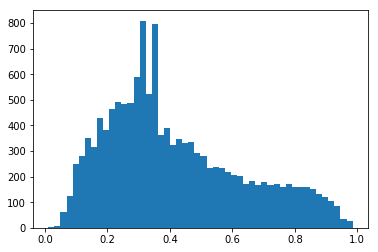


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.92      0.76      0.83     11203
           1       0.33      0.64      0.44      2137

    accuracy                           0.74     13340
   macro avg       0.62      0.70      0.63     13340
weighted avg       0.82      0.74      0.77     13340

CONFUSION MATRIX:


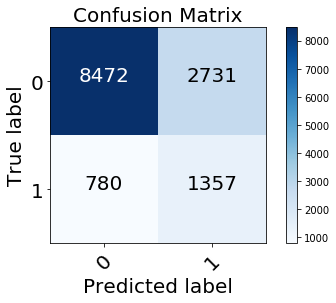

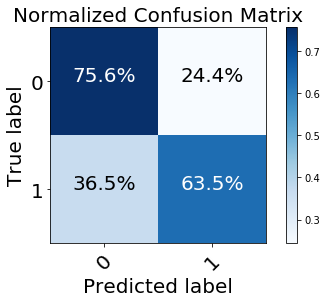

ROC CURVE:


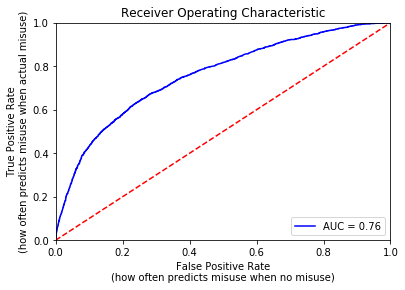

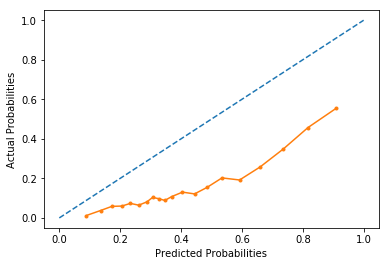

In [16]:
#Generate LR Predictions
preds = modelLR.predict(valX)
predProbs = modelLR.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelLRPredProbs.npy', arr=predProbs)

#Summarize
resultsSummary(preds, predProbs)

PREDICTION COUNTS:
 [[    0 11474]
 [    1  1866]]

ACCURACY SCORES:
Model Accuracy: 82.41%
Model ROC AUC:  73.26%
Brier Score Loss:  0.16
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.363892
std             0.124282
min             0.194923
25%             0.263315
50%             0.353720
75%             0.402132
max             0.758462

DISTRIBUTION OF PREDICTED PROBABILITIES:


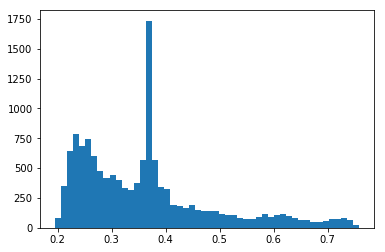


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90     11203
           1       0.44      0.39      0.41      2137

    accuracy                           0.82     13340
   macro avg       0.66      0.65      0.66     13340
weighted avg       0.82      0.82      0.82     13340

CONFUSION MATRIX:


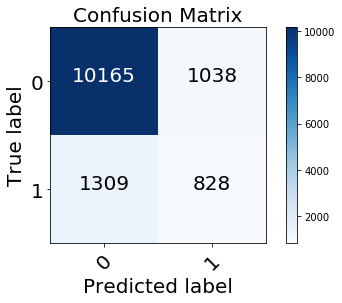

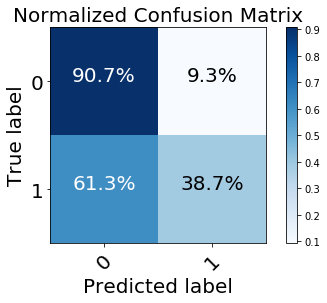

ROC CURVE:


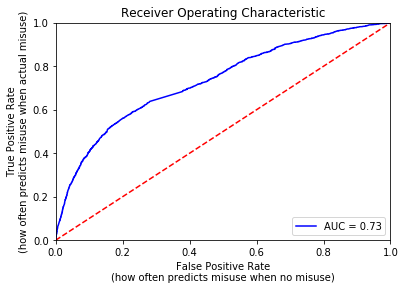

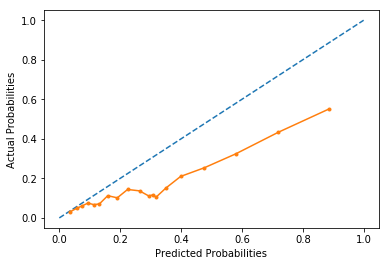

In [17]:
#Generate XGB Predictions
preds = modelXGB.predict(valX)
predProbs = modelXGB.predict_proba(valX)[:, 1]

np.save(file=dataDir+'modelXGBPredProbs.npy', arr=predProbs)

#Summarize
resultsSummary(preds, predProbs)

# 5. Calibration

This section seeks to calibrate the model. That is, it makes the acutal probabilities from the model align with the actual probabilities.

In [18]:
#Now we'll try to calibrate the model
runCalibration = True

## 5.1 Calibrate Logistic Regression Model

In [19]:
if runCalibration:
    calibratorLR = CalibratedClassifierCV(modelLR, cv=5, method='isotonic')
    calibratorLR.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\camke\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will b

PREDICTION COUNTS:
 [[    0 12664]
 [    1   676]]

ACCURACY SCORES:
Model Accuracy: 85.43%
Model ROC AUC:  77.46%
Brier Score Loss:  0.111
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.160142
std             0.147074
min             0.000000
25%             0.069718
50%             0.100190
75%             0.196804
max             0.938636

DISTRIBUTION OF PREDICTED PROBABILITIES:


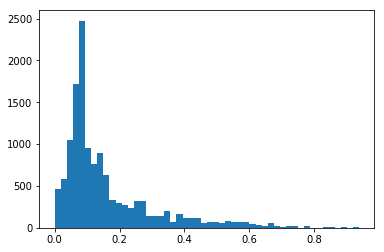


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92     11203
           1       0.64      0.20      0.31      2137

    accuracy                           0.85     13340
   macro avg       0.75      0.59      0.61     13340
weighted avg       0.83      0.85      0.82     13340

CONFUSION MATRIX:


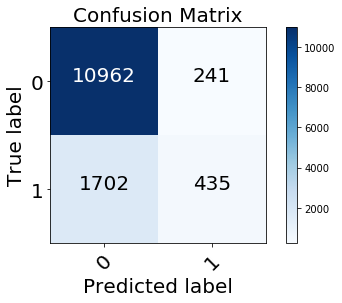

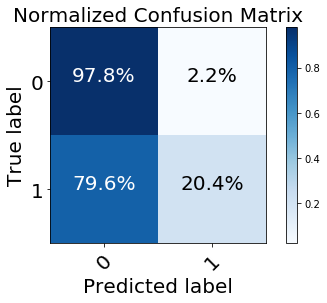

ROC CURVE:


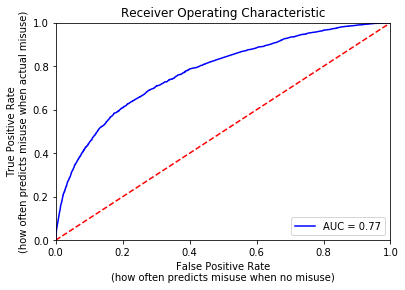

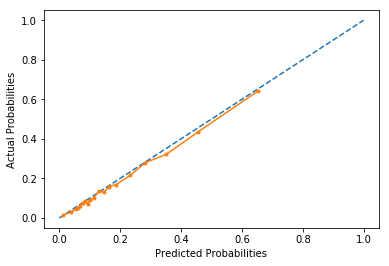

In [20]:
#Now recalculate predictions and print results
if runCalibration:
    preds = calibratorLR.predict(valX)
    predProbs = calibratorLR.predict_proba(valX)[:,1]
    resultsSummary(preds, predProbs)

## 5.2 Calibrate XGBoost Model

In [21]:
if runCalibration:
    calibratorXGB = CalibratedClassifierCV(modelXGB, cv=10)
    #CK YOU LEFT OFF ON THE LINE ABOVE. 2 THINGS:
    #1. cv='prefit' I THINK CAN BE FIXED WITH RE-SORTING THE DATA. MIGHT WANT TO MAKE A MODULE FOR THIS, OR ADD
    #A DEF TO PREPROCESSING FILE. INCREASING TO cv=10 (FROM 3) GAVE A HUGE IMPROVEMENT.
    #2. CONSIDER USING THE TEST (NOT VAL) DATA FOR CALIBRATION PREDICTIONS. THIS MIGHT THWART OVERFITTING.
    #YOU'LL ALSO HAVE TO CHANGE THE RESULTS SUMMARY FUNCTION FROM valY TO testY (OR BETTER YET, PASS IT IN).
    calibratorXGB.fit(valX, valY)

C:\Users\camke\Anaconda3\lib\site-packages\sklearn\utils\validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


PREDICTION COUNTS:
 [[    0 12706]
 [    1   634]]

ACCURACY SCORES:
Model Accuracy: 87.86%
Model ROC AUC:  85.41%
Brier Score Loss:  0.0928
  (Brier Score Loss evaluates probability estimates, lower is better)

DESCRIPTIVE STATS ON PREDICTED PROBABILITIES:
       Descriptive Stats
count       13340.000000
mean            0.161342
std             0.133869
min             0.075291
25%             0.087239
50%             0.101770
75%             0.165519
max             0.815467

DISTRIBUTION OF PREDICTED PROBABILITIES:


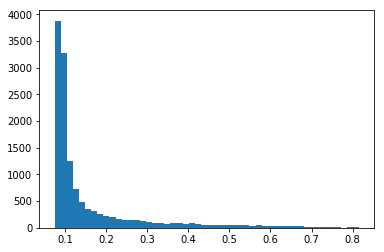


CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.88      0.99      0.93     11203
           1       0.91      0.27      0.42      2137

    accuracy                           0.88     13340
   macro avg       0.89      0.63      0.67     13340
weighted avg       0.88      0.88      0.85     13340

CONFUSION MATRIX:


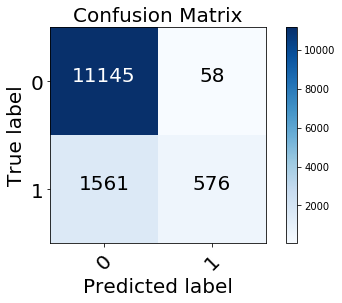

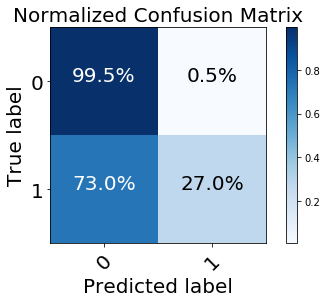

ROC CURVE:


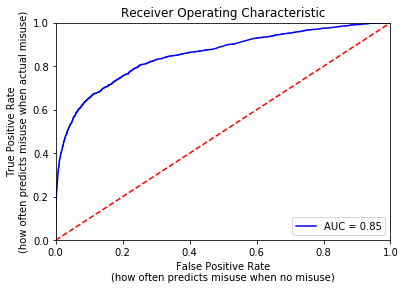

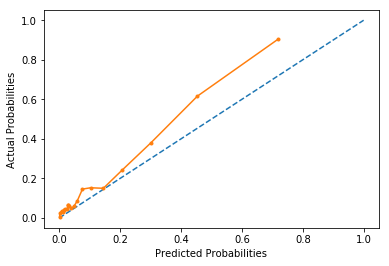

In [22]:
#Now recalculate predictions and print results
if runCalibration:
    preds = calibratorXGB.predict(valX)
    predProbs = calibratorXGB.predict_proba(valX)[:,1]
    resultsSummary(preds, predProbs)

# 6. Save Model to Disk

Saving the model to disk at this point saves time, specifically so we don't have to re-train it every time we want to use it for predictions, feature importance, report generation, etc.

In [23]:
#Save model and any other necessary files
joblib.dump(modelLR, dataDir+'modelLR.model')
joblib.dump(modelXGB, dataDir+'modelXGB.model')

if runCalibration:
    joblib.dump(calibratorXGB, dataDir+'calibXGB.model')

#Save data files necessary for calculating feature importance
valX.to_pickle(dataDir+'valX.pickle.zip')
testX.to_pickle(dataDir+'testX.pickle.zip')
'''Note, the .to_pickle command INFERS zip compression based on the '.zip'
extension. Changing the extension will result in a 1GB file instead of a 
compressed file.
''';